# Peptide: Penetratin

Sequence: RQIKIWFQNRRMKWKK
1. Temperature: 70C
2. Amino Acid Stock Concentration:0.4
3. Activator: HATU or PyAOP
4. Act. Base concentration: 20% DIEA in DMF
5. Deprot.Base: 40% Piperidine in DMF
7. Wash Solvent: DMF
8. Deprotection Strokes: 10
9. Coupling Strokes: 10


## Notes
Resin: 50 mg ChemMatrix Rink-Amide resin

In [3]:
peptide = ["arg","gln","ile","lys","ile","trp","phe","gln","asn","arg","arg","met","lys","trp","lys","lys"]
amino_acid_set = set(peptide)

print(amino_acid_set)




{'ile', 'phe', 'arg', 'trp', 'met', 'lys', 'asn', 'gln'}


In [4]:
import mechwolf as mw
from datetime import timedelta

# define solvents and reagents
dmf = mw.Vessel("DMF", name="dmf")

pip = mw.Vessel("40% Piperidine in DMF", name="pip")

diea = mw.Vessel("20% DIEA in DMF", name="diea")

hatu = mw.Vessel("0.38 M HATU in DMF", name="hatu")
pyaop = mw.Vessel("0.38 M PyAOP in DMF", name = "pyaop")

# define amino acids
# All amino acids aod 0.4 M solutions in DMF.
lys = mw.Vessel("0.4M fmoc_lys_boc in DMF", name="lys")
met = mw.Vessel("0.4M fmoc_met in DMF", name="met")
trp = mw.Vessel("0.4M fmoc_trp_boc in DMF", name="trp")
arg = mw.Vessel("0.4M fmoc_arg_pbf in DMF", name="arg")
gln = mw.Vessel("0.4M fmoc_gln_trt in DMF", name="gln")
phe = mw.Vessel("0.4M fmoc_phe_oh in DMF", name="phe")
asn = mw.Vessel("0.4M fmoc_asn_trt in DMF", name="asn")
ile = mw.Vessel("0.4M fmoc_ile_oh in DMF", name="ile")

output = mw.Vessel("waste", name="output")

# define pumps
activator_pump = mw.VarianPump(name="activator_pump", max_rate = '5 mL/min', serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI4UT-if00-port0')
amino_pump = mw.VarianPump(name="amino_pump", max_rate = '5 mL/min', serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI4DV-if00-port0')
diea_pump = mw.VarianPump(name="diea_pump", max_rate = '5 mL/min', serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI43N-if00-port0')

mixer = mw.TMixer(name='mixer')
reactor = mw.Vessel("Peptide synthesis reactor with 50 mg ChemMatrix Rink Amide Resin", name="reactor")

# define sensors
uv = mw.LabJack(name="uv")

# define valve
amino_mapping = {lys: 1,
                     gln: 2,
                     ile: 3,
                     trp: 5,
                     arg: 6,
                     phe: 7,
                     asn: 8,
                     met: 9,
                     dmf: 10}

amino_valve = mw.ViciValve(name="amino_valve", mapping=amino_mapping, serial_port = '/dev/serial/by-id/usb-FTDI_FT232R_USB_UART_AH06396Q-if00-port0')

act_mapping={hatu: 2, pyaop:1, pip: 9, dmf: 10}

activator_valve = mw.ViciValve(name="activator_valve", mapping=act_mapping, serial_port = '/dev/serial/by-id/usb-FTDI_FT232R_USB_UART_AH063AL3-if00-port0')


def fat_tube(len):
    return mw.Tube(length=len, ID="1/16 in", OD="1/8 in", material="PFA")

def thin_tube(len):
    return mw.Tube(length=len, ID="0.030 in", OD="1/16 in", material="PFA")

def thinner_tube(len):
    return mw.Tube(length=len, ID="0.020 in", OD="1/16 in", material="PFA")

heating_loop = mw.Tube(length = "5 ft", ID = "0.030 in", OD = "1/16 in", material = "Stainless Steel")

valve_tube = thinner_tube("12 cm")

A = mw.Apparatus("Peptide Synthesizer")

A.add([hatu, pyaop], activator_valve, fat_tube("101 cm"))
A.add([dmf, pip], activator_valve, fat_tube("101 cm"))
A.add(activator_valve, activator_pump, valve_tube)
A.add(activator_pump, mixer, thinner_tube("46 cm"))
A.add(lys, amino_valve, thin_tube("64.9 cm"))
A.add(gln, amino_valve, thin_tube("53 cm"))
A.add(ile, amino_valve, thin_tube("46.2 cm"))
A.add(trp, amino_valve, thin_tube("36.1 cm"))
A.add(arg, amino_valve, thin_tube("31 cm"))
A.add(phe, amino_valve, thin_tube("25.6 cm"))
A.add(asn, amino_valve, thin_tube("25 cm"))
A.add(met, amino_valve, thin_tube("28.8 cm"))
A.add(dmf, amino_valve, fat_tube("113 cm"))
A.add(amino_valve, amino_pump, valve_tube)
A.add(amino_pump, mixer, thinner_tube("46 cm"))
A.add(diea, diea_pump, fat_tube("98 cm"))
A.add(diea_pump, mixer, thinner_tube("65 cm"))
A.add(mixer, reactor, heating_loop)
A.add(reactor, uv, thinner_tube("50 cm"))

#A.describe()
#A.visualize(graph_attr=dict(splines="ortho", nodesep="0.75"), label_tubes=False)

P = mw.Protocol(A)
start = timedelta(seconds=0)

# how much time to leave the pumps off before and after switching the valve
switching_time = timedelta(seconds=0.2)



def pump_time(number_strokes, flow_rate=5):
    # Computes the length of time to run the Varian Prostar pump with a 5 mL/min pump head at the desired flow rate
    # to get the desired number of pump delivery cycles (pump strokes). The volume of each
    # pump stroke is 0.039239 mL.
    # Returns time in minutes.
    time_seconds = 60 * ((number_strokes * 0.039239) / flow_rate)
    return time_seconds


def add_rinse(time_seconds):
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting="dmf")
    P.add([amino_pump, activator_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")
    start += rinse_duration


def add_diea_rinse(time_seconds):
    # Washes with all three pumps while coupling agent and amino acid flushes out
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting="dmf")
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")

    start += rinse_duration

#######

add_rinse(30)
for amino in reversed(peptide):

    # Turn on amino acid, coupling agent, and diea. does not implement about a priming period
    coupling_duration = timedelta(seconds=(pump_time(number_strokes=30))) + 2 * switching_time

    P.add(amino_valve, start=start, duration=coupling_duration, setting=amino)
    P.add(activator_valve, start=start, duration=coupling_duration, setting="hatu")
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=coupling_duration - 2 * switching_time, rate="5 mL/min")

    start += coupling_duration

    add_diea_rinse(pump_time(number_strokes=10))
    add_rinse(30)

    # Fmoc removal
    pip_addition_duration = timedelta(seconds=(pump_time(number_strokes=20))) + 2 * switching_time

    P.add([amino_pump, activator_pump], start=start + switching_time, duration=pip_addition_duration - 2 * switching_time, rate="5 mL/min")
    P.add(amino_valve, start=start, duration=pip_addition_duration, setting="dmf")
    P.add(activator_valve, start=start, duration=pip_addition_duration, setting="pip")

    start += pip_addition_duration

    add_rinse(30)

add_rinse(10)
add_rinse(10)
P.add(uv, start = timedelta(seconds = 0), stop = start, rate = "5 Hz")



In [5]:
A.summarize()

### Components

| Name            | Type       |
|-----------------|------------|
| uv              | LabJack    |
| mixer           | TMixer     |
| amino_pump      | VarianPump |
| activator_pump  | VarianPump |
| diea_pump       | VarianPump |
| reactor         | Vessel     |
| pip             | Vessel     |
| dmf             | Vessel     |
| diea            | Vessel     |
| hatu            | Vessel     |
| pyaop           | Vessel     |
| lys             | Vessel     |
| met             | Vessel     |
| trp             | Vessel     |
| arg             | Vessel     |
| gln             | Vessel     |
| phe             | Vessel     |
| asn             | Vessel     |
| ile             | Vessel     |
| amino_valve     | ViciValve  |
| activator_valve | ViciValve  |

### Tubing 

| From            | To              | Length             | Inner Diameter | Outer Diameter | Volume             | Material        |
|-----------------|-----------------|--------------------|----------------|----------------|--------------------|-----------------|
| hatu            | activator_valve | 101 centimeter     | 0.0625 inch    | 0.125 inch     | 1.9991 milliliter  | PFA             |
| pyaop           | activator_valve | 101 centimeter     | 0.0625 inch    | 0.125 inch     | 1.9991 milliliter  | PFA             |
| dmf             | activator_valve | 101 centimeter     | 0.0625 inch    | 0.125 inch     | 1.9991 milliliter  | PFA             |
| pip             | activator_valve | 101 centimeter     | 0.0625 inch    | 0.125 inch     | 1.9991 milliliter  | PFA             |
| activator_valve | activator_pump  | 12 centimeter      | 0.02 inch      | 0.0625 inch    | 0.0243 milliliter  | PFA             |
| activator_pump  | mixer           | 46 centimeter      | 0.02 inch      | 0.0625 inch    | 0.0932 milliliter  | PFA             |
| lys             | amino_valve     | 64.9 centimeter    | 0.03 inch      | 0.0625 inch    | 0.296 milliliter   | PFA             |
| gln             | amino_valve     | 53 centimeter      | 0.03 inch      | 0.0625 inch    | 0.2417 milliliter  | PFA             |
| ile             | amino_valve     | 46.2 centimeter    | 0.03 inch      | 0.0625 inch    | 0.2107 milliliter  | PFA             |
| trp             | amino_valve     | 36.1 centimeter    | 0.03 inch      | 0.0625 inch    | 0.1646 milliliter  | PFA             |
| arg             | amino_valve     | 31 centimeter      | 0.03 inch      | 0.0625 inch    | 0.1414 milliliter  | PFA             |
| phe             | amino_valve     | 25.6 centimeter    | 0.03 inch      | 0.0625 inch    | 0.1167 milliliter  | PFA             |
| asn             | amino_valve     | 25 centimeter      | 0.03 inch      | 0.0625 inch    | 0.114 milliliter   | PFA             |
| met             | amino_valve     | 28.8 centimeter    | 0.03 inch      | 0.0625 inch    | 0.1313 milliliter  | PFA             |
| dmf             | amino_valve     | 113 centimeter     | 0.0625 inch    | 0.125 inch     | 2.2366 milliliter  | PFA             |
| amino_valve     | amino_pump      | 12 centimeter      | 0.02 inch      | 0.0625 inch    | 0.0243 milliliter  | PFA             |
| amino_pump      | mixer           | 46 centimeter      | 0.02 inch      | 0.0625 inch    | 0.0932 milliliter  | PFA             |
| diea            | diea_pump       | 98 centimeter      | 0.0625 inch    | 0.125 inch     | 1.9397 milliliter  | PFA             |
| diea_pump       | mixer           | 65 centimeter      | 0.02 inch      | 0.0625 inch    | 0.1317 milliliter  | PFA             |
| mixer           | reactor         | 5 foot             | 0.03 inch      | 0.0625 inch    | 0.695 milliliter   | Stainless Steel |
| reactor         | uv              | 50 centimeter      | 0.02 inch      | 0.0625 inch    | 0.1013 milliliter  | PFA             |
| **Total**       | n/a             | 13090.0 millimeter | n/a            | n/a            | 14.7525 milliliter | n/a             |

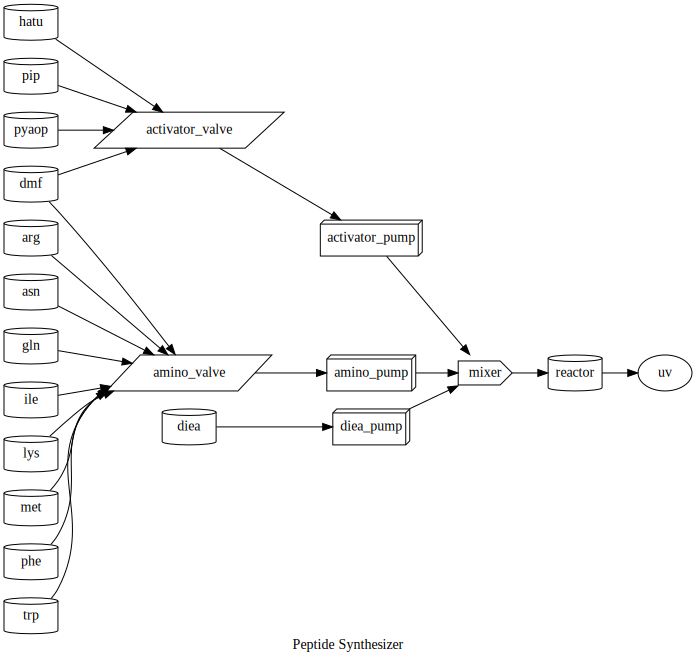

In [6]:
#Visualize the apparatus
A.visualize()

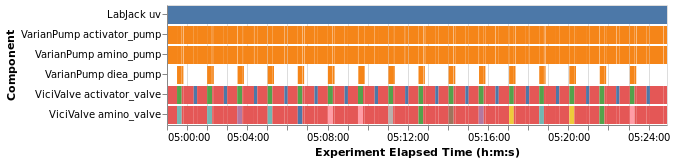

In [7]:
P.visualize()

In [8]:
#Returns immediately with an Experiment object that will update as it gets new data
E = P.execute()

Execute? [y/N]: y


TypeError: can't pickle _thread.lock objects

In [7]:
#Visualize the experiment with live updating
Exp.visualize()

Loading BokehJS ...

INFO:root:Executing: {'time': <Quantity(30.2, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump amino_pump> at 1553541539.04046
INFO:root:Executing: {'time': <Quantity(30.2, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump activator_pump> at 1553541539.0593963
INFO:root:Executing: {'time': <Quantity(30.4, 'second')>, 'params': {'setting': 1}} on <ViciValve activator_valve> at 1553541539.2477615
INFO:root:Executing: {'time': <Quantity(30.4, 'second')>, 'params': {'setting': 5}} on <ViciValve amino_valve> at 1553541539.270847
INFO:root:Executing: {'time': <Quantity(30.6, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump amino_pump> at 1553541539.4406826
INFO:root:Executing: {'time': <Quantity(30.6, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump diea_pump> at 1553541539.4749732
INFO:root:Executing: {'time': <Quantity(30.6, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump activator_pump> at 1553541539.4881177
INFO:root:Executing: {'time': <

INFO:root:Executing: {'time': <Quantity(263.8868, 'second')>, 'params': {'setting': 10}} on <ViciValve amino_valve> at 1553541772.7368731
INFO:root:Executing: {'time': <Quantity(264.0868, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump activator_pump> at 1553541772.9359622
INFO:root:Executing: {'time': <Quantity(264.0868, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump amino_pump> at 1553541772.9447384
INFO:root:Executing: {'time': <Quantity(264.0868, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump diea_pump> at 1553541772.9524765
INFO:root:Executing: {'time': <Quantity(268.79548, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump activator_pump> at 1553541777.6362414
INFO:root:Executing: {'time': <Quantity(268.79548, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump amino_pump> at 1553541777.648167
INFO:root:Executing: {'time': <Quantity(268.79548, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump diea_pump> at 1553541777.6598

INFO:root:Executing: {'time': <Quantity(497.5736, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump amino_pump> at 1553542006.4212656
INFO:root:Executing: {'time': <Quantity(527.5735999999999, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump activator_pump> at 1553542036.414685
INFO:root:Executing: {'time': <Quantity(527.5735999999999, 'second')>, 'params': {'rate': '0 mL/min'}} on <VarianPump amino_pump> at 1553542036.4396188
INFO:root:Executing: {'time': <Quantity(527.7736, 'second')>, 'params': {'setting': 10}} on <ViciValve amino_valve> at 1553542036.6170044
INFO:root:Executing: {'time': <Quantity(527.7736, 'second')>, 'params': {'setting': 9}} on <ViciValve activator_valve> at 1553542036.62548
INFO:root:Executing: {'time': <Quantity(527.9736, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump activator_pump> at 1553542036.814441
INFO:root:Executing: {'time': <Quantity(527.9736, 'second')>, 'params': {'rate': '5 mL/min'}} on <VarianPump amino_pump> at 155

Done monitoring uv


In [ ]:
#Inspect the protocol steps that ran successfully.
Exp.protocol.json()

In [ ]:
Exp.executed_procedures